# Imports Here

In [ ]:
# Step 1: Mount Google Drive
import cv2
import json
import numpy as np
import os
import random
import re
import tensorflow as tf

from google.colab import drive
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, jaccard_score, hamming_loss
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, VGG16, MobileNetV3Large, EfficientNetB0, MobileNetV2
from tqdm import tqdm
from typing import Any, Dict, List, Tuple


drive.mount('/content/drive')

Mounted at /content/drive


# Read The Files

In [ ]:
# === PATHS ===
videos_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/labels"
label_map_file = "/content/drive/MyDrive/Project/cholect50-challenge-val/label_mapping.txt"

In [ ]:
# Load all target names from the first JSON (dynamic)
example_json = next(f for f in os.listdir(labels_path) if f.endswith('.json'))
with open(os.path.join(labels_path, example_json), 'r') as f:
    data = json.load(f)
# Build mapping: target_id -> target_name
target_categories = data['categories']['target']
# Correct dynamic target mapping
target_id_to_name = {int(k): v for k, v in data['categories']['target'].items()}
num_targets = len(target_id_to_name)


# Load triplet -> target mapping from label_mapping.txt
target_mapping = {}
with open(os.path.join(label_map_file), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split(',')
        triplet_id = int(parts[0])
        target_id = int(parts[3])
        target_mapping[triplet_id] = target_id

X = []
Y = []

# Loop through all video folders
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)
    if not os.path.isdir(vid_path):
        continue

    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)
    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    with open(label_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']

    # Build frame_number -> list of target IDs
    frame_target = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        targets_in_frame = []

        for triplet in triplets:
            triplet_id = triplet[0]
            target_id = target_mapping.get(triplet_id, -1)
            if target_id != -1:
                targets_in_frame.append(target_id)

        if len(targets_in_frame) == 0:
            continue  # skip frames with no valid target

        frame_target[frame_number] = targets_in_frame

    # Process frames
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))
        targets = frame_target.get(frame_number)
        if not targets:
            continue

        # Create multi-hot vector
        multi_hot = np.zeros(num_targets, dtype=np.int64)
        for target_id in targets:
            multi_hot[target_id] = 1

        # Read image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(multi_hot)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.int64)

print(f"Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Example multi-hot target vectors:\n{Y[:10]}")
print(f"Target ID -> Name mapping:\n{target_id_to_name}")

Total frames processed: 1209
X shape: (1209, 224, 224, 3), Y shape: (1209, 15)
Example multi-hot target vectors:
[[1 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Target ID -> Name mapping:
{0: 'gallbladder', 1: 'cystic_plate', 2: 'cystic_duct', 3: 'cystic_artery', 4: 'cystic_pedicle', 5: 'blood_vessel', 6: 'fluid', 7: 'abdominal_wall_cavity', 8: 'liver', 9: 'adhesion', 10: 'omentum', 11: 'peritoneum', 12: 'gut', 13: 'specimen_bag', 14: 'null_target'}


# Exploratory Data Analysis

In [ ]:
import numpy as np

# Y_train is assumed to be a numpy array of shape (num_frames, num_classes)
class_sums = np.sum(Y, axis=0)
for i, s in enumerate(class_sums):
    print(f"Class {i}: {s} positive samples")

Class 0: 360 positive samples
Class 1: 56 positive samples
Class 2: 143 positive samples
Class 3: 140 positive samples
Class 4: 42 positive samples
Class 5: 41 positive samples
Class 6: 120 positive samples
Class 7: 56 positive samples
Class 8: 124 positive samples
Class 9: 0 positive samples
Class 10: 36 positive samples
Class 11: 0 positive samples
Class 12: 3 positive samples
Class 13: 132 positive samples
Class 14: 100 positive samples


In [ ]:
import numpy as np

# Y is your multi-hot label array of shape (num_samples, num_classes)
class_counts = np.sum(Y, axis=0)  # sum over samples for each class
valid_classes = np.where(class_counts > 0)[0]

print("Classes with at least one frame:", valid_classes)
print("Number of valid classes:", len(valid_classes))

Classes with at least one frame: [ 0  1  2  3  4  5  6  7  8 10 12 13 14]
Number of valid classes: 13


# Data Augmentation

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- Function to augment a single frame ---
def augment_frame(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    #k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    #img = tf.image.rot90(img, k)
    img = tf.image.random_brightness(img, max_delta=0.1)
    # img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

# --- Identify classes with at least 1 positive ---
class_counts = np.sum(Y, axis=0)
valid_classes = np.where(class_counts > 0)[0]

# --- Target samples per class ---
target_samples = 200

aug_X = []
aug_Y = []

for cls in valid_classes:
    current_count = np.sum(Y[:, cls])
    if current_count >= target_samples:
        continue  # skip majority classes
    needed = target_samples - current_count
    idx = np.where(Y[:, cls] == 1)[0]
    if len(idx) == 0:
        continue  # skip if no samples
    np.random.shuffle(idx)
    for i in range(needed):
        img = X[idx[i % len(idx)]]  # loop over available frames
        label = Y[idx[i % len(idx)]]
        aug_img = augment_frame(img)
        aug_X.append(aug_img.numpy())
        aug_Y.append(label)

# Combine augmented data with original
X_balanced = np.concatenate([X, np.array(aug_X)], axis=0)
Y_balanced = np.concatenate([Y, np.array(aug_Y)], axis=0)

print("Original dataset size:", len(X))
print("Balanced dataset size:", len(X_balanced))

Original dataset size: 1209
Balanced dataset size: 2616


In [ ]:
import numpy as np

# X is your numpy array of shape (N, H, W, 3), values in 0..1 (if normalized)
# If X is 0..255, remove the /255.0 part

X_min = np.min(X_balanced)
X_max = np.max(X_balanced)
X_mean = np.mean(X_balanced)

print(f"✅ Pixel value stats for X:")
print(f"Min pixel value: {X_min}")
print(f"Max pixel value: {X_max}")
print(f"Mean pixel value: {X_mean:.4f}")

# Optionally, compute per-channel stats
X_mean_channels = np.mean(X_balanced, axis=(0,1,2))
X_min_channels = np.min(X_balanced, axis=(0,1,2))
X_max_channels = np.max(X_balanced, axis=(0,1,2))

print(f"\nPer-channel mean: {X_mean_channels}")
print(f"Per-channel min: {X_min_channels}")
print(f"Per-channel max: {X_max_channels}")

✅ Pixel value stats for X:
Min pixel value: -0.0999746322631836
Max pixel value: 1.0998696088790894
Mean pixel value: 0.2527

Per-channel mean: [0.13058071 0.12799756 0.11724734]
Per-channel min: [-0.09947496 -0.09997463 -0.09997463]
Per-channel max: [1.0998696 1.0996475 1.0996475]


In [ ]:
import numpy as np

# Count positives per class
target_counts = Y_balanced.sum(axis=0)
print("Target counts per class:", target_counts)

# Find valid (non-empty) classes
valid_mask = target_counts > 0
valid_indices = np.where(valid_mask)[0]

# Filter Y_balanced to keep only valid classes
Y_balanced_filtered = Y_balanced[:, valid_mask]

print(f"✅ Removed {np.sum(~valid_mask)} empty classes")
print(f"New Y_balanced shape: {Y_balanced_filtered.shape}")
print("Remaining class indices:", valid_indices)

Target counts per class: [585 200 200 200 200 200 202 201 220   0 201   0 200 212 208]
✅ Removed 2 empty classes
New Y_balanced shape: (2616, 13)
Remaining class indices: [ 0  1  2  3  4  5  6  7  8 10 12 13 14]


# Class Weights

In [ ]:
import numpy as np

# Y_balanced now only has valid classes
target_counts = Y_balanced_filtered.sum(axis=0)  # number of positive samples per class
total_frames = Y_balanced_filtered.shape[0]
num_classes = Y_balanced_filtered.shape[1]

# Multi-label class weight formula: inverse frequency
class_weights = total_frames / (num_classes * target_counts)

# Optional: normalize to have mean=1
class_weights = class_weights / np.mean(class_weights)

print("✅ Class weights:")
for i, w in enumerate(class_weights):
    print(f"Class {i}: {w:.3f}")

✅ Class weights:
Class 0: 0.366
Class 1: 1.071
Class 2: 1.071
Class 3: 1.071
Class 4: 1.071
Class 5: 1.071
Class 6: 1.061
Class 7: 1.066
Class 8: 0.974
Class 9: 1.066
Class 10: 1.071
Class 11: 1.011
Class 12: 1.030


#Data Splits


In [ ]:
# --- Split into train/val/test ---
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_balanced, Y_balanced_filtered, test_size=0.3, random_state=42, shuffle=True
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, shuffle=True
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1831
Val size: 392
Test size: 393


In [ ]:
import tensorflow as tf

BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, Y, batch_size=BATCH_SIZE, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

train_ds = make_dataset(X_train, Y_train, training=True)
val_ds   = make_dataset(X_val, Y_val, training=False)
test_ds  = make_dataset(X_test, Y_test, training=False)

In [ ]:
num_targets = Y_balanced_filtered.shape[1]

# Delete vals for Ram Management

In [ ]:
del X, Y, X_temp, Y_temp, X_balanced, Y_balanced, X_test, Y_test, X_val, Y_val, X_train, Y_train

# Model Train

In [ ]:
IMG_SIZE = 224
drop_rate = 0.3
num_heads = 4  # multihead attention heads
embed_dim = 128  # feature dimension for attention
num_instruments = num_targets
epoch_size = 20

def build_model_with_backbone(backbone_model, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_instruments):
    """
    Builds a model with a specified backbone, Multi-Head Attention, and dense layers.

    Args:
        backbone_model: The Keras application model class (e.g., MobileNetV2, ResNet50V2).
        input_shape: The input shape of the images.
        num_classes: The number of output classes.

    Returns:
        A Keras Model.
    """
    # === Backbone ===
    # Ensure include_top is False to get the convolutional base
    # Handle potential differences in input_shape argument name
    try:
        base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    except TypeError:
         base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape) # Some models don't have pooling arg


    base.trainable = False  # Freeze backbone initially

    inp = layers.Input(shape=input_shape)
    x = base(inp)

    # Flatten spatial dimensions for attention: (batch, seq_len, channels)
    # Handle cases where base output might be flattened already or have different ranks
    if len(x.shape) == 4:
        b, h, w, c = x.shape
        x_flat = layers.Reshape((-1, c))(x)  # seq_len = h*w
    elif len(x.shape) == 3:
         x_flat = x # Assume already (batch, seq_len, channels)
    else:
         raise ValueError(f"Unexpected backbone output shape: {x.shape}")


    # === Multi-Head Attention ===
    # Adjust key_dim if embed_dim is larger than backbone channels
    attention_key_dim = min(embed_dim, x_flat.shape[-1])
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=attention_key_dim)(x_flat, x_flat)
    attn_out = layers.GlobalAveragePooling1D()(attn_out)

    # === Dense Head ===
    x = layers.Dropout(drop_rate)(attn_out)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation='sigmoid')(x)  # multi-label output

    model = models.Model(inputs=inp, outputs=out)
    return model

# Example usage:
# model_resnet = build_model_with_backbone(ResNet50V2)
# model_inception = build_model_with_backbone(InceptionV3)
# model_xception = build_model_with_backbone(Xception)
# model_vgg16 = build_model_with_backbone(VGG16)
# model_mobilenetv3 = build_model_with_backbone(MobileNetV3Large)
# model_efficientnet = build_model_with_backbone(EfficientNetB0)

print("Functions to build models with different backbones created.")

Functions to build models with different backbones created.


In [ ]:
from sklearn.metrics import precision_recall_curve

def calculate_multi_label_metrics(model: Any, val_ds: Any) -> Dict[str, Any]:
    """
    Calculates multi-label metrics with automatic per-class threshold optimization.
    """

    print("Collecting true labels and generating predictions...")
    y_true = np.concatenate([y for _, y in val_ds], axis=0)
    y_probs = np.concatenate([model.predict(x) for x, _ in val_ds], axis=0)

    num_classes = y_true.shape[1]

    # ----------------------------
    # Per-class threshold optimization (maximize F1)
    # ----------------------------
    optimal_thresholds = []
    for i in range(num_classes):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_index = np.argmax(f1_scores)
        # Edge case: threshold array is shorter by one compared to precision/recall
        if best_index >= len(thresh):
            best_index = len(thresh) - 1
        best_thresh = thresh[best_index]
        optimal_thresholds.append(best_thresh)

    print("\n🎯 Per-Class Optimal Thresholds:")
    for i, t in enumerate(optimal_thresholds):
        print(f" Class {i}: {t:.3f}")

    # Apply optimized thresholds
    y_pred = np.zeros_like(y_probs)
    for i in range(num_classes):
        y_pred[:, i] = (y_probs[:, i] >= optimal_thresholds[i]).astype(int)

    print(f"\n🔢 Total Positives After Thresholding: {y_pred.sum()}")

    # ----------------------------
    # Micro metrics
    # ----------------------------
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

    # ----------------------------
    # Macro metrics
    # ----------------------------
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # ----------------------------
    # Per-class probability metrics
    # ----------------------------
    avg_precision = [average_precision_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]
    roc_auc = [roc_auc_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]

    # ----------------------------
    # Multi-label specific metrics
    # ----------------------------
    jaccard_micro = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
    jaccard_macro = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_true, y_pred)

    # ----------------------------
    # Print results
    # ----------------------------
    print("\n=== Multi-label metrics (Optimized Thresholds) ===")
    print(f"Precision micro: {precision_micro:.4f}, Recall micro: {recall_micro:.4f}, F1 micro: {f1_micro:.4f}")
    print(f"Precision macro: {precision_macro:.4f}, Recall macro: {recall_macro:.4f}, F1 macro: {f1_macro:.4f}")
    print(f"Jaccard index (micro): {jaccard_micro:.4f}, Jaccard index (macro): {jaccard_macro:.4f}")
    print(f"Hamming loss: {hamming:.4f}")
    print("Average precision per class:", np.round(avg_precision, 3))
    print("ROC-AUC per class:", np.round(roc_auc, 3))

    return {
        'optimal_thresholds': optimal_thresholds,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'jaccard_micro': jaccard_micro,
        'jaccard_macro': jaccard_macro,
        'hamming_loss': hamming,
        'avg_precision_per_class': avg_precision,
        'roc_auc_per_class': roc_auc,
        'total_positives_after_thresholding': int(y_pred.sum()) # Adding total positives
    }

In [ ]:
model = build_model_with_backbone(MobileNetV2)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 13)        │      1,677 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,047,885 (19.26 MB)

 Trainable params: 2,789,901 (10.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        fl = alpha * tf.pow(1 - y_pred, gamma) * y_true * bce + \
             (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true) * bce
        # apply per-class weights
        weighted_fl = fl * class_weights
        return tf.reduce_mean(weighted_fl)
    return loss

In [ ]:
model_backbones = ['ResNet50V2', 'InceptionV3', 'Xception', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0', 'MobileNetV2']
# model_backbones = ['MobileNetV2']

In [ ]:
import pandas as pd

# List to store evaluation results for each model
all_results = []

# Iterate through the list of model backbones
for backbone_name in model_backbones:
    print(f"\n--- Processing Model: {backbone_name} ---")

    # Step 3: Build model
    print("Building model...")
    try:
        backbone_class = globals()[backbone_name]
        model = build_model_with_backbone(backbone_class)
        print(f"Model {backbone_name} built successfully.")
        # model.summary() # Optional: Print summary

        # Extract trainable parameters (in millions)
        trainable_params = model.count_params() / 1_000_000.0
        print(f"Trainable parameters: {trainable_params:.2f}M")

    except Exception as e:
        print(f"Error building model {backbone_name}: {e}")
        continue  # Skip to the next backbone

    # Step 4: Compile model
    print("Compiling model...")
    try:
        # Use the focal loss with class weights and PR AUC metric
        loss_fn = focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=loss_fn,
            metrics=[tf.keras.metrics.AUC(curve='PR', multi_label=True, name='pr_auc')]
        )
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Error compiling model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 5: Train model
    print("Training model...")
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epoch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
            ],
            verbose=0 # Suppress verbose output during loop
        )
        print(f"Model {backbone_name} trained successfully.")
    except Exception as e:
        print(f"Error training model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 6: Evaluate model and collect results
    print("Evaluating model on test set...")
    try:
        test_results = calculate_multi_label_metrics(model, test_ds)
        print(f"\n--- Evaluation Results for {backbone_name} ---")

        # Add model name and trainable parameters to the results dictionary
        test_results['Model'] = backbone_name
        test_results['Trainable Params (M)'] = trainable_params

        # Append results to the list
        all_results.append(test_results)

        # Step 7: Save the trained model
        model_save_path = f"/content/drive/MyDrive/Project/surgical_target_recognition_model_{backbone_name}.keras"
        model.save(model_save_path)
        print(f"Model saved to: {model_save_path}")

    except Exception as e:
        print(f"Error evaluating model {backbone_name}: {e}")


    # Clean up for the next iteration to free up memory
    del model
    tf.keras.backend.clear_session()
    print(f"Finished processing {backbone_name}. Memory cleared.")

print("\n--- All models processed. ---")

# Convert results to DataFrame and save to CSV
if all_results:
    results_df = pd.DataFrame(all_results)

    # Define the path to save the CSV
    results_csv_path = "/content/drive/MyDrive/Project/surgical_target_recognition_model_evaluation_results.csv"

    try:
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n✅ Evaluation results saved to: {results_csv_path}")
        display(results_df) # Display the DataFrame
    except Exception as e:
        print(f"\nError saving results to CSV: {e}")
else:
    print("\nNo results to save.")


--- Processing Model: ResNet50V2 ---
Building model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model ResNet50V2 built successfully.
Trainable parameters: 28.03M
Compiling model...
Model compiled successfully.
Training model...
Model ResNet50V2 trained successfully.
Evaluating model on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━

,optimal_thresholds,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,jaccard_micro,jaccard_macro,hamming_loss,avg_precision_per_class,roc_auc_per_class,total_positives_after_thresholding,Model,Trainable Params (M)
0,"[0.45198265, 0.49001753, 0.39510214, 0.2972176...",0.849438,0.828947,0.839068,0.867853,0.849330,0.854959,0.722753,0.765389,0.028381,"[0.8330672536163323, 0.9799094458048849, 0.745...","[0.9216437532867553, 0.9982948086396362, 0.972...",445,ResNet50V2,28.026637
1,"[0.3795258, 0.6054648, 0.3393973, 0.22903699, ...",0.827660,0.853070,0.840173,0.848818,0.868525,0.854697,0.724395,0.765237,0.028968,"[0.8626496639604669, 0.9765062523683212, 0.732...","[0.9371196754563894, 0.9941265630920804, 0.934...",470,InceptionV3,26.264621
2,"[0.30476338, 0.31604087, 0.15362811, 0.4017581...",0.867133,0.815789,0.840678,0.879949,0.842594,0.859097,0.725146,0.769829,0.027598,"[0.8049166694827599, 0.9913552077642445, 0.772...","[0.897678611674555, 0.9991474043198181, 0.9532...",429,Xception,25.323317
3,"[0.41566408, 0.3655296, 0.31478286, 0.5049717,...",0.847666,0.756579,0.799537,0.856971,0.788199,0.813537,0.666023,0.706410,0.033862,"[0.787117365716495, 0.9930695144354476, 0.6264...","[0.8762677484787018, 0.9994316028798786, 0.880...",407,VGG16,15.832653
4,"[0.38264722, 0.59435165, 0.23704565, 0.2278956...",0.394322,0.548246,0.458716,0.509566,0.545735,0.494587,0.297619,0.342699,0.115482,"[0.47708575858326374, 0.7830618659268838, 0.29...","[0.7202689504920743, 0.9501705191360363, 0.754...",634,MobileNetV3Large,5.089613
5,"[0.3101608, 0.21091318, 0.22000548, 0.23242554...",0.118339,0.750000,0.204423,0.132468,0.703125,0.207891,0.113848,0.117726,0.521041,"[0.18227758818403228, 0.07947123441637802, 0.1...","[0.41193373901284647, 0.5051155740810913, 0.50...",2890,EfficientNetB0,6.839472
6,"[0.34442312, 0.32600203, 0.29341584, 0.3722138...",0.898551,0.815789,0.855172,0.902495,0.846315,0.870122,0.746988,0.787121,0.024662,"[0.825257120951065, 0.9940775789515766, 0.7666...","[0.895650214108632, 0.9995263357332322, 0.9612...",414,MobileNetV2,5.047885


✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_target_recognition_model_evaluation_results.csv


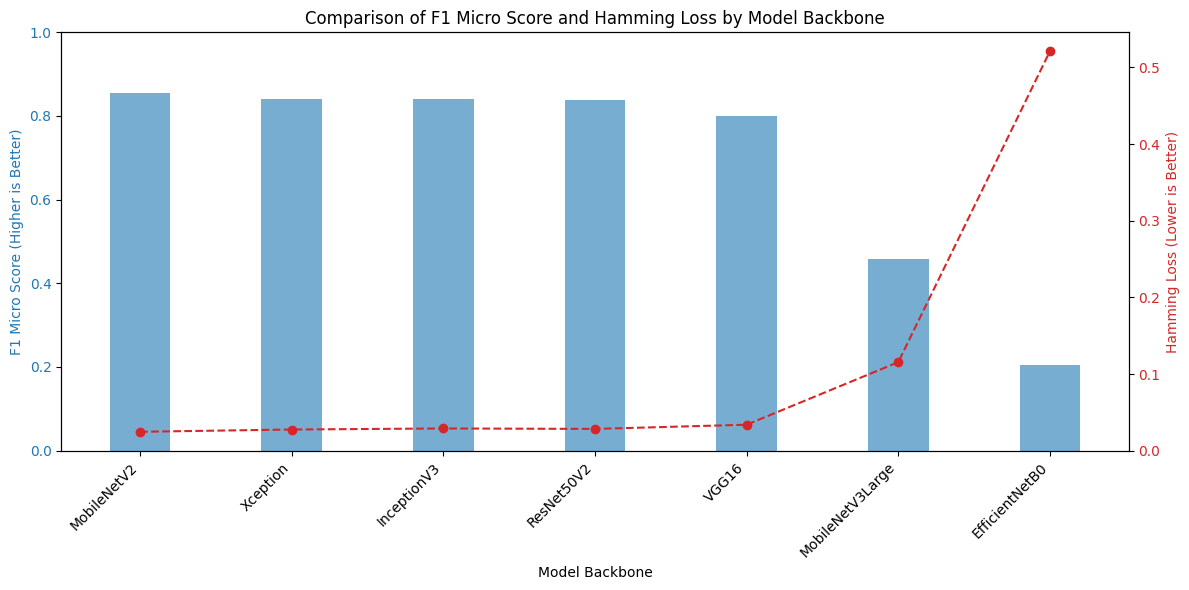

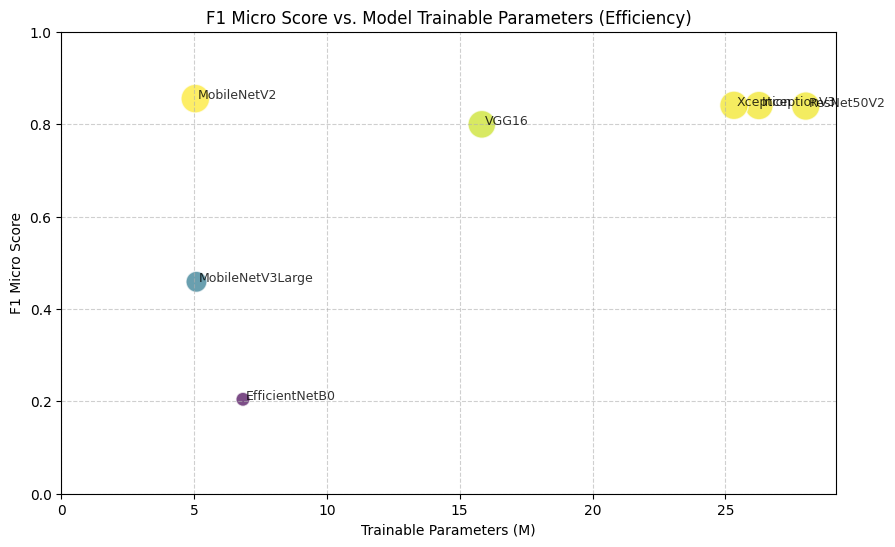

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_target_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Rename columns for clarity in plots if necessary (adjust as needed)
    # Example: df = df.rename(columns={'f1_micro': 'F1 Micro', 'hamming_loss': 'Hamming Loss'})

    # Sort by F1 Micro for better visualization in the first plot
    df_sorted = df.sort_values(by='f1_micro', ascending=False)

    # ----------------------------------------------------------------------
    ## Chart 1: F1 Micro Score and Hamming Loss Comparison
    # ----------------------------------------------------------------------

    # Create a figure with two subplots (sharing the Model axis)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot F1 Micro on the left y-axis (ax1)
    color = 'tab:blue'
    ax1.set_xlabel('Model Backbone')
    ax1.set_ylabel('F1 Micro Score (Higher is Better)', color=color)
    ax1.bar(df_sorted['Model'], df_sorted['f1_micro'], color=color, alpha=0.6, width=0.4, align='center')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.0)
    x_positions = ax1.get_xticks() # Get the auto-generated positions
    ax1.set_xticks(x_positions)    # Set the positions explicitly
    ax1.set_xticklabels(df_sorted['Model'], rotation=45, ha="right") # Apply the labels

    # Create a second y-axis for Hamming Loss
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Hamming Loss (Lower is Better)', color=color)
    ax2.plot(df_sorted['Model'], df_sorted['hamming_loss'], color=color, marker='o', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0)

    plt.title('Comparison of F1 Micro Score and Hamming Loss by Model Backbone')
    fig.tight_layout()
    plt.savefig('model_comparison_f1_hamming.png')
    # Command to display the first chart
    plt.show()
    plt.close(fig)

    # ----------------------------------------------------------------------
    ## Chart 2: F1 Micro vs. Trainable Parameters (Efficiency Trade-off)
    # ----------------------------------------------------------------------

    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['Trainable Params (M)'], # Use the column from the CSV
        df['f1_micro'],          # Use the column from the CSV
        s=df['f1_micro'] * 500,  # Size based on F1 micro
        c=df['f1_micro'],        # Color based on F1 micro
        cmap='viridis',
        alpha=0.7,
        edgecolors='w',
        linewidths=1
    )

    # Annotate each point with the model name
    for i, row in df.iterrows():
        plt.annotate(
            row['Model'],
            (row['Trainable Params (M)'] + 0.1, row['f1_micro']), # Use columns from CSV
            fontsize=9,
            alpha=0.8
        )

    plt.xlabel('Trainable Parameters (M)')
    plt.ylabel('F1 Micro Score')
    plt.title('F1 Micro Score vs. Model Trainable Parameters (Efficiency)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0, 1.0)

    plt.savefig('model_efficiency_tradeoff.png')
    # Command to display the second chart
    plt.show()
    plt.close()
else:
    print("DataFrame is empty. Cannot generate plots.")

✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_target_recognition_model_evaluation_results.csv


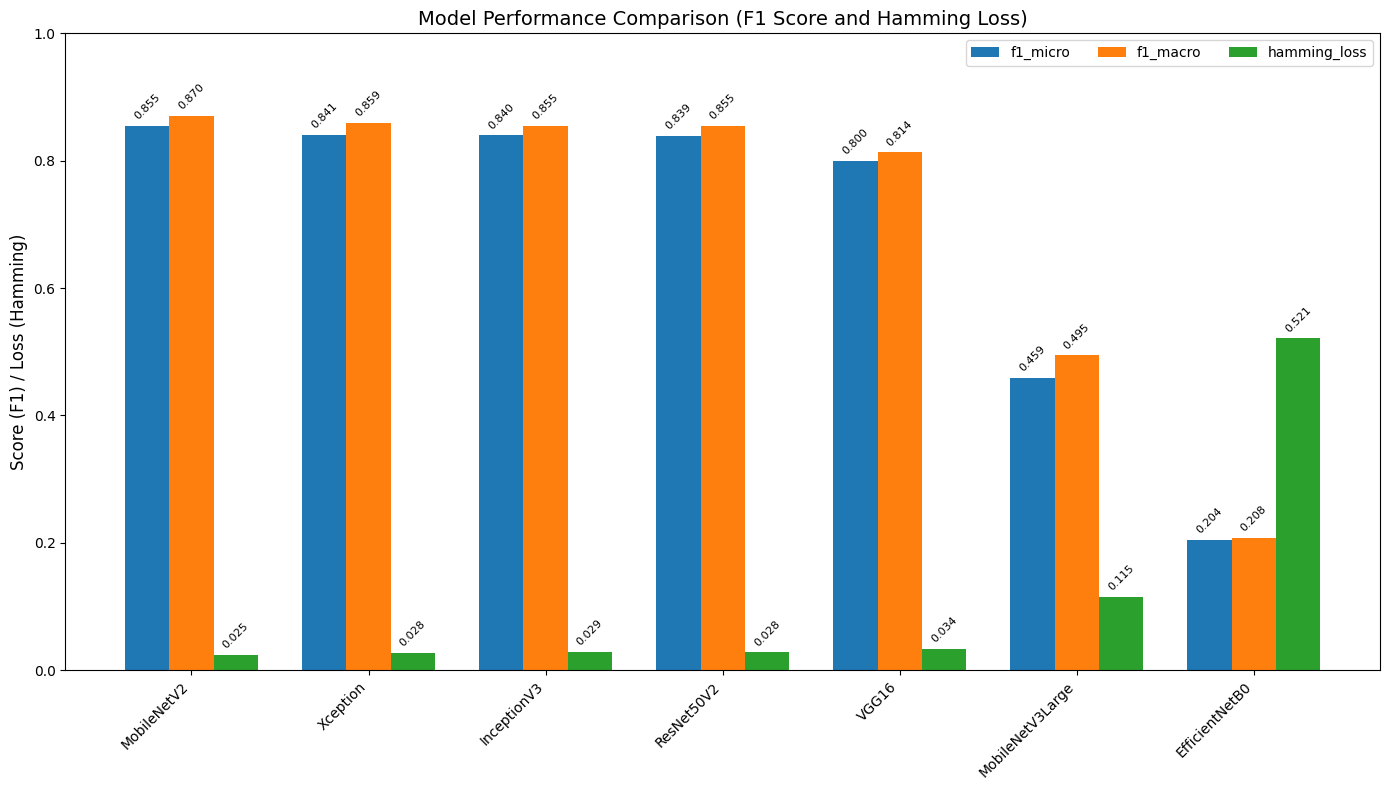

--- Model Performance Metrics ---
| Model            |   f1_micro |   f1_macro |   hamming_loss |
|:-----------------|-----------:|-----------:|---------------:|
| MobileNetV2      |   0.855172 |   0.870122 |      0.0246624 |
| Xception         |   0.840678 |   0.859097 |      0.0275984 |
| InceptionV3      |   0.840173 |   0.854697 |      0.0289685 |
| ResNet50V2       |   0.839068 |   0.854959 |      0.0283813 |
| VGG16            |   0.799537 |   0.813537 |      0.0338618 |
| MobileNetV3Large |   0.458716 |   0.494587 |      0.115482  |
| EfficientNetB0   |   0.204423 |   0.207891 |      0.521041  |

--- Model Parameter Comparison (in Millions) ---
| Model            |   Trainable Params (M) |
|:-----------------|-----------------------:|
| ResNet50V2       |               28.0266  |
| InceptionV3      |               26.2646  |
| Xception         |               25.3233  |
| VGG16            |               15.8327  |
| EfficientNetB0   |                6.83947 |
| MobileNetV3Large

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_target_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Sort by F1 micro for better visualization (descending order)
    df_sorted = df.sort_values(by='f1_micro', ascending=False).reset_index(drop=True)

    # 1. Performance Metrics Bar Chart
    metrics = ['f1_micro', 'f1_macro', 'hamming_loss'] # Use column names from the CSV
    x = np.arange(len(df_sorted['Model']))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax1 = plt.subplots(figsize=(14, 8))

    for i, metric in enumerate(metrics):
        offset = width * multiplier
        rects = ax1.bar(x + offset, df_sorted[metric], width, label=metric)
        ax1.bar_label(rects, padding=3, fmt='%.3f', rotation=45, fontsize=8)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel('Score (F1) / Loss (Hamming)', fontsize=12)
    ax1.set_title('Model Performance Comparison (F1 Score and Hamming Loss)', fontsize=14)
    ax1.set_xticks(x + width, df_sorted['Model'], rotation=45, ha='right', fontsize=10)
    ax1.legend(loc='upper right', ncol=3)
    ax1.set_ylim(0, 1.0)
    plt.tight_layout()

    plt.savefig('model_performance_comparison.png')
    plt.show()
    plt.close()

    # 2. Parameter Count DataFrame
    # Create a DataFrame for parameter comparison and print as markdown
    # Use column names from the CSV
    params_df = df[['Model', 'Trainable Params (M)']].sort_values(
        by='Trainable Params (M)', ascending=False
    ).reset_index(drop=True)


    print("--- Model Performance Metrics ---")
    print(df_sorted[['Model', 'f1_micro', 'f1_macro', 'hamming_loss']].to_markdown(index=False)) # Use column names from the CSV

    print("\n--- Model Parameter Comparison (in Millions) ---")
    print(params_df.to_markdown(index=False))

else:
    print("DataFrame is empty. Cannot generate plots or tables.")